**Practical 4:**

Area of interest: Eastern boundary of the Antarctic peninsula



In [2]:
#Importing all the necessary programs:
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmocean
import numpy as np
import xarray as xr
import io 
import zipfile
import requests
import glob
import os
import gzip
import shutil
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

*Plot 1*

A large figure with the map of the region bathymetry, using an adequate colormap.

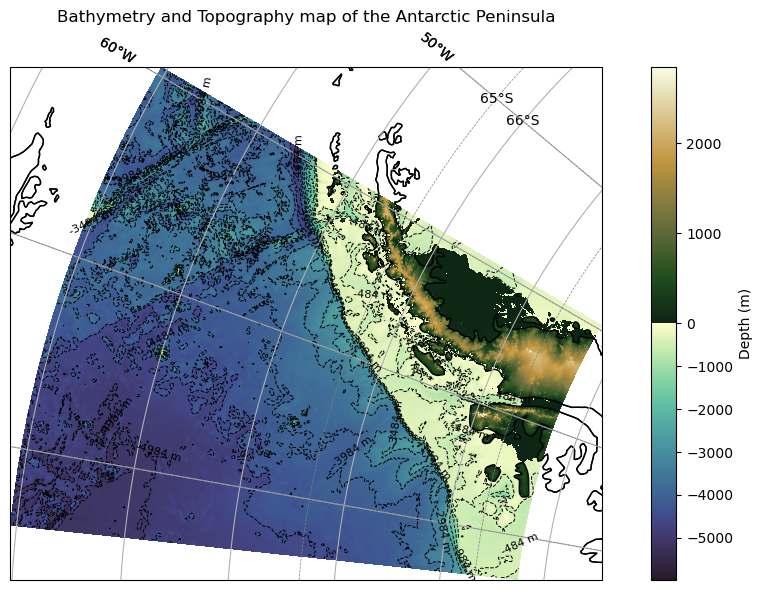

In [5]:
# Loading bathymetry dataset 
bathy = xr.open_dataset('GMRTv4_3_0_20250318topo (1).grd')

#Getting the data:
lon = bathy['lon']  
lat = bathy['lat']  
bathymetry = bathy['altitude'] 

# Colour normalization with zero (sea level) as the midpoint
vmin, vmax = float(bathymetry.min()), float(bathymetry.max())
midpoint = 0  # Sea level at 0m

norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)  

# Contrast for land and sea
cmap = cmocean.cm.topo  

# Creating figure with correct projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Plot bathymetry and land elevation
pcm = ax.pcolormesh(lon, lat, bathymetry, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Add bathymetry contours
contour = ax.contour(lon, lat, bathymetry, levels=np.arange(vmin, 0, 500),
                      colors="black", linewidths=0.7, transform=ccrs.PlateCarree())
ax.clabel(contour, fmt='%d m', colors='black', fontsize=8)  

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.coastlines()
ax.gridlines(draw_labels=True)

#Adding contours
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.ylocator = mticker.FixedLocator(np.arange(-90, -60, 5)) 

# Colorbar
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', label='Depth / Elevation (m)')
cbar.set_label("Depth (m)")
# Elevation is positive for land, negative for depth (ocean)

# Title
plt.title("Bathymetry and Topography map of the Antarctic Peninsula")
plt.tight_layout()  
plt.savefig("plot1.jpg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

*Plot 2:*

In [7]:
#Loading the chlorophyll data:
chl_data = xr.open_dataset("/Users/chloelevey/Documents/LVYCHL001-SCDM25/P4/ESACCI-OC-MAPPED-CLIMATOLOGY-1M_MONTHLY_4km_PML_CHL-fv5.0.nc")

chl_data

<xarray.Dataset>
Dimensions:  (time: 12, lon: 8640, lat: 4320)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 1997-12-01
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
Data variables:
    crs      int32 ...
    chlor_a  (time, lat, lon) float32 ...
Attributes: (12/53)
    CDI:                               Climate Data Interface version ?? (htt...
    history:                           Tue Apr 27 20:27:21 2021: cdo selvar,c...
    source:                            NASA SeaWiFS  L1A and L2 R2018.0 LAC a...
    institution:                       Plymouth Marine Laboratory
    Conventions:                       CF-1.7
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    ...                                ...
    time_coverage_start:               199801010000Z
    time_coverage_end:                 202001312359Z
    id:                                ESACCI-OC-MAPPED-CLIMATOLOGY-1M_MONTHL...
    NCO:                               4.7.2
    nco_openmp_thread_number:          1
    CDO:                               Climate Data Operators version 1.9.3 (...

In [8]:
#Making a data array:
da_chl_data = chl_data['chlor_a'] 

In [9]:
#Log transforming the data:
da_chl_log = np.log(da_chl_data)

In [10]:
#Checking min and max values:
print(da_chl_data.min(),da_chl_data.max(),da_chl_data.mean())

#Making an array for the mean:
da_chl_mean = da_chl_data.mean(dim='time') 

<xarray.DataArray 'chlor_a' ()>
array(0.001) <xarray.DataArray 'chlor_a' ()>
array(99.48895264) <xarray.DataArray 'chlor_a' ()>
array(0.40058345, dtype=float32)


In [11]:
##Using the log transformed data for the plot:

#Log mean:
da_chl_log_mean = da_chl_log.mean(dim='time') 

#Setting extent:
extent = [-60, -85, -58, -70]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

#Masking NANs in data set:
da_chl_log_mean_masked = da_chl_log_mean.where(~np.isnan(da_chl_log_mean))


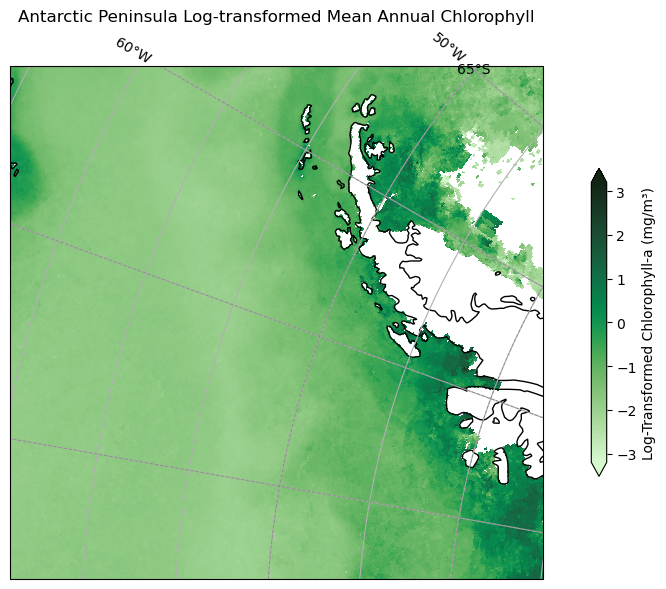

In [12]:
#Plotting:
# Figure and axis:
fig, axis = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Plot chlorophyll data 
da_chl_log_mean_masked.plot(ax=axis, transform=ccrs.PlateCarree(),cmap=cmocean.cm.algae, 
                            cbar_kwargs={'orientation': 'vertical', 'shrink': 0.6,'label': 'Log-Transformed Chlorophyll-a (mg/m³)'}, robust = True)

# Add coastlines and gridlines
axis.set_extent(extent, crs=ccrs.PlateCarree())
axis.coastlines()
gl = axis.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

gl = axis.gridlines(draw_labels=True, linestyle="--", linewidth=0.7, color="gray", alpha=0.7)

#making sure that the lat and long points are evenly spaced:
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))  
gl.ylocator = mticker.FixedLocator(np.arange(-90, -60, 5))    

#Title and saving:
plt.title("Antarctic Peninsula Log-transformed Mean Annual Chlorophyll")
plt.tight_layout()
plt.savefig("plot2.jpg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

*Plot 3:*

In [17]:
#Grouping the log-chlorophyll data by month:
monthly_mean_chl = da_chl_log.groupby('time.month').mean()

In [18]:
#Adding months:
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

monthly_mean_chl = monthly_mean_chl.assign_coords(month=("month", month_names))

In [19]:
#Setting the extent
region_extent = dict(lon=slice(-85, -60), lat=slice(-58, -70))  
monthly_mean_chl_region = monthly_mean_chl.sel(**region_extent)

/var/folders/w8/mpdvw0cn1n310fwby2rvy00m0000gn/T/ipykernel_12577/3539103866.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, name in zip(g.axes.flat, month_names):


<Figure size 1400x1200 with 0 Axes>

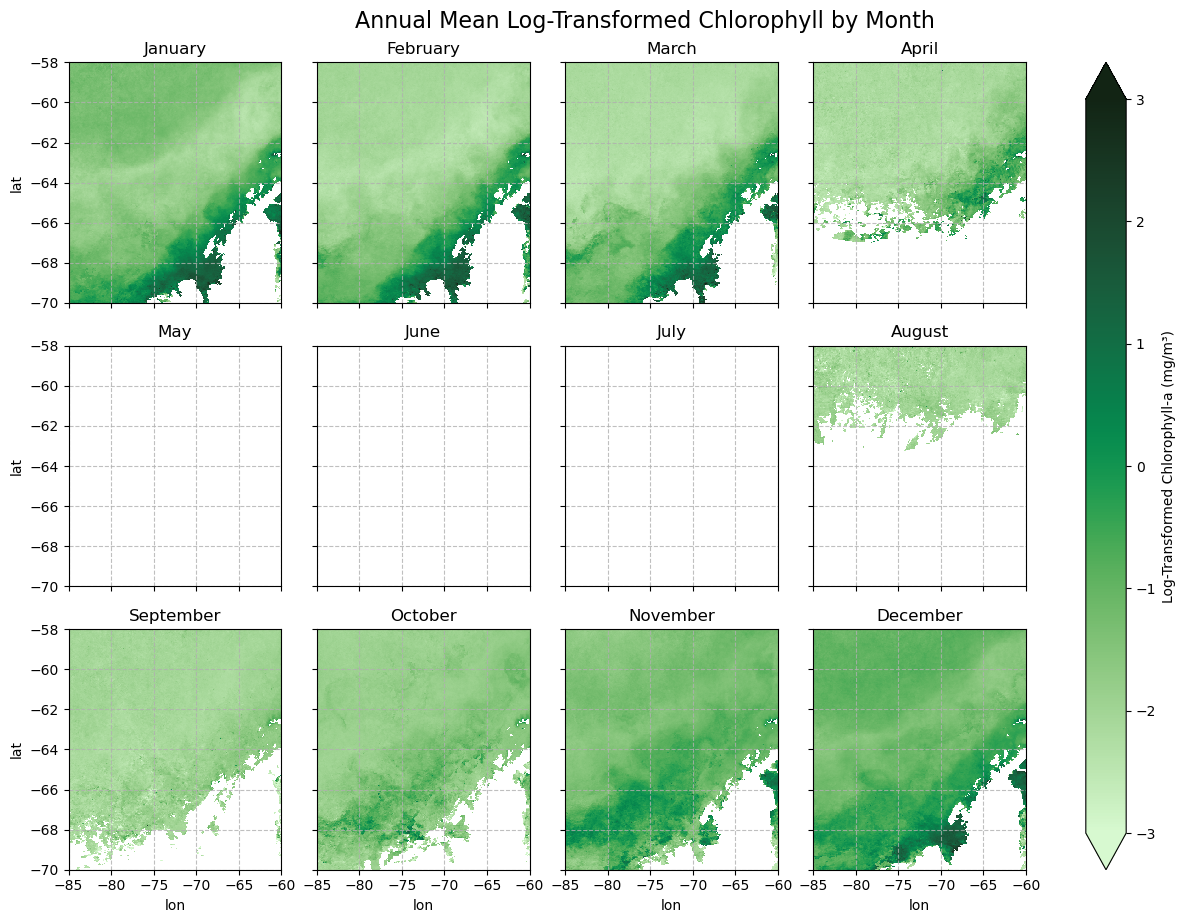

In [46]:
#Plotting the figure:
fig = plt.figure(figsize=(14, 12))

g = monthly_mean_chl_region.plot(col='month', col_wrap=4, cmap=cmocean.cm.algae, vmin=-3., vmax=3.,cbar_kwargs={'label': 'Log-Transformed Chlorophyll-a (mg/m³)'})

# Looping through each axis to set titles and gridlines:
for ax, name in zip(g.axes.flat, month_names):
    ax.set_title(name)
    ax.grid(True, linestyle='--', alpha=0.8)  # Add gridlines

plt.suptitle("Annual Mean Log-Transformed Chlorophyll by Month", fontsize=16, y=1.02) 
plt.savefig("plot3.jpg")
plt.show()

*Plot 4:*

In [28]:
# Log transforming chlor_a for extent:
log_chlor_a = np.log10(chl_data['chlor_a'].sel(lon=slice(-85, -60), lat=slice(-58, -70)))
    
# Monthly mean for the extent:
regional_mean = log_chlor_a.groupby('time.month').mean(dim=['lat', 'lon'])

#Single point near high chlorophyll area:
single_point = log_chlor_a.sel(lon=-68, lat=-65, method='nearest')
# Print the exact coordinates
print(f"Exact Longitude: {single_point.lon.values}")
print(f"Exact Latitude: {single_point.lat.values}")
    
#Monthly mean for the single point:
single_point_mean = single_point.groupby('time.month').mean()

Exact Longitude: -67.97916666666667
Exact Latitude: -65.02083333333331


In [30]:
# Remove NaNs before finding max value
log_chlor_a_clean = log_chlor_a.where(~np.isnan(log_chlor_a), drop=True)

#Finding index of max log-transformed chlorophyll 
max_idx = log_chlor_a_clean.argmax(dim=["lat", "lon"])

# Extract the corresponding latitude and longitude
max_lat = log_chlor_a_clean.lat[max_idx["lat"].values].values
max_lon = log_chlor_a_clean.lon[max_idx["lon"].values].values

print(f"Max log chlor_a at lat: {max_lat}, lon: {max_lon}")

Max log chlor_a at lat: [-67.4375     -69.10416667 -68.35416667 -65.72916667 -61.02083333
 -67.8125     -68.14583333 -62.60416667 -68.85416667], lon: [-68.02083333 -68.4375     -67.22916667 -67.14583333 -71.6875
 -75.72916667 -74.1875     -60.64583333 -67.72916667]


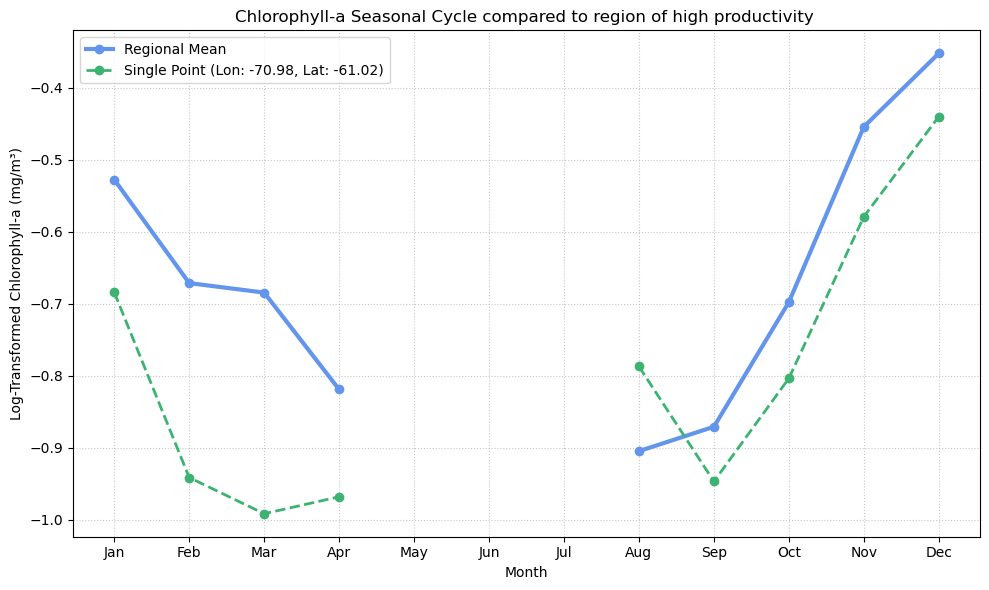

In [36]:
#Plotting:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), regional_mean.values, 
             label='Regional Mean', linewidth=3, color='cornflowerblue', marker='o')
plt.plot(range(1, 13), single_point_mean.values, 
             label=f'Single Point (Lon: {single_point.lon.values:.2f}, Lat: {single_point.lat.values:.2f})', 
             linewidth=2, color='mediumseagreen', linestyle='--', marker='o')
    
plt.title('Chlorophyll-a Seasonal Cycle compared to region of high productivity ', fontsize=12)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Log-Transformed Chlorophyll-a (mg/m³)', fontsize=10)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

#Saving
plt.tight_layout()
plt.savefig("plot4.jpg")
plt.show()